<!-- dom:TITLE: Data Analysis and Machine Learning: Logistic Regression -->
# Data Analysis and Machine Learning: Logistic Regression
<!-- dom:AUTHOR: Morten Hjorth-Jensen at Department of Physics, University of Oslo & Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University -->
<!-- Author: -->  
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and National Superconducting Cyclotron Laboratory, Michigan State University

Date: **Sep 16, 2020**

Copyright 1999-2020, Morten Hjorth-Jensen. Released under CC Attribution-NonCommercial 4.0 license




## Plans for week 38

* Thursday: Summary of regression methods and discussion of project 1. We revisit also cross-validation and bootstrap as resampling techniques with examples

* Friday: Logistic Regression

## Thursday:

Material will added during Wednesday 16

## Friday: Intro to Logistic Regression


<!-- !split  -->
## Logistic Regression

In linear regression our main interest was centered on learning the
coefficients of a functional fit (say a polynomial) in order to be
able to predict the response of a continuous variable on some unseen
data. The fit to the continuous variable $y_i$ is based on some
independent variables $\hat{x}_i$. Linear regression resulted in
analytical expressions for standard ordinary Least Squares or Ridge
regression (in terms of matrices to invert) for several quantities,
ranging from the variance and thereby the confidence intervals of the
parameters $\hat{\beta}$ to the mean squared error. If we can invert
the product of the design matrices, linear regression gives then a
simple recipe for fitting our data.

<!-- !split  -->
## Classification problems


Classification problems, however, are concerned with outcomes taking
the form of discrete variables (i.e. categories). We may for example,
on the basis of DNA sequencing for a number of patients, like to find
out which mutations are important for a certain disease; or based on
scans of various patients' brains, figure out if there is a tumor or
not; or given a specific physical system, we'd like to identify its
state, say whether it is an ordered or disordered system (typical
situation in solid state physics); or classify the status of a
patient, whether she/he has a stroke or not and many other similar
situations.

The most common situation we encounter when we apply logistic
regression is that of two possible outcomes, normally denoted as a
binary outcome, true or false, positive or negative, success or
failure etc.

## Optimization and Deep learning

Logistic regression will also serve as our stepping stone towards
neural network algorithms and supervised deep learning. For logistic
learning, the minimization of the cost function leads to a non-linear
equation in the parameters $\hat{\beta}$. The optimization of the
problem calls therefore for minimization algorithms. This forms the
bottle neck of all machine learning algorithms, namely how to find
reliable minima of a multi-variable function. This leads us to the
family of gradient descent methods. The latter are the working horses
of basically all modern machine learning algorithms.

We note also that many of the topics discussed here on logistic 
regression are also commonly used in modern supervised Deep Learning
models, as we will see later.


<!-- !split  -->
## Basics

We consider the case where the dependent variables, also called the
responses or the outcomes, $y_i$ are discrete and only take values
from $k=0,\dots,K-1$ (i.e. $K$ classes).

The goal is to predict the
output classes from the design matrix $\hat{X}\in\mathbb{R}^{n\times p}$
made of $n$ samples, each of which carries $p$ features or predictors. The
primary goal is to identify the classes to which new unseen samples
belong.

Let us specialize to the case of two classes only, with outputs
$y_i=0$ and $y_i=1$. Our outcomes could represent the status of a
credit card user that could default or not on her/his credit card
debt. That is

$$
y_i = \begin{bmatrix} 0 & \mathrm{no}\\  1 & \mathrm{yes} \end{bmatrix}.
$$

## Linear classifier

Before moving to the logistic model, let us try to use our linear
regression model to classify these two outcomes. We could for example
fit a linear model to the default case if $y_i > 0.5$ and the no
default case $y_i \leq 0.5$.

We would then have our 
weighted linear combination, namely

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
\hat{y} = \hat{X}^T\hat{\beta} +  \hat{\epsilon},
\label{_auto1} \tag{1}
\end{equation}
$$

where $\hat{y}$ is a vector representing the possible outcomes, $\hat{X}$ is our
$n\times p$ design matrix and $\hat{\beta}$ represents our estimators/predictors.

## Some selected properties

The main problem with our function is that it takes values on the
entire real axis. In the case of logistic regression, however, the
labels $y_i$ are discrete variables. A typical example is the credit
card data discussed below here, where we can set the state of
defaulting the debt to $y_i=1$ and not to $y_i=0$ for one the persons
in the data set (see the full example below).

One simple way to get a discrete output is to have sign
functions that map the output of a linear regressor to values $\{0,1\}$,
$f(s_i)=sign(s_i)=1$ if $s_i\ge 0$ and 0 if otherwise. 
We will encounter this model in our first demonstration of neural networks. Historically it is called the "perceptron" model in the machine learning
literature. This model is extremely simple. However, in many cases it is more
favorable to use a ``soft" classifier that outputs
the probability of a given category. This leads us to the logistic function.


## The logistic function

The perceptron is an example of a ``hard classification" model. We
will encounter this model when we discuss neural networks as
well. Each datapoint is deterministically assigned to a category (i.e
$y_i=0$ or $y_i=1$). In many cases, it is favorable to have a "soft"
classifier that outputs the probability of a given category rather
than a single value. For example, given $x_i$, the classifier
outputs the probability of being in a category $k$.  Logistic regression
is the most common example of a so-called soft classifier. In logistic
regression, the probability that a data point $x_i$
belongs to a category $y_i=\{0,1\}$ is given by the so-called logit function (or Sigmoid) which is meant to represent the likelihood for a given event,

$$
p(t) = \frac{1}{1+\mathrm \exp{-t}}=\frac{\exp{t}}{1+\mathrm \exp{t}}.
$$

Note that $1-p(t)= p(-t)$.

## Examples of likelihood functions used in logistic regression and nueral networks


The following code plots the logistic function, the step function and other functions we will encounter from here and on.

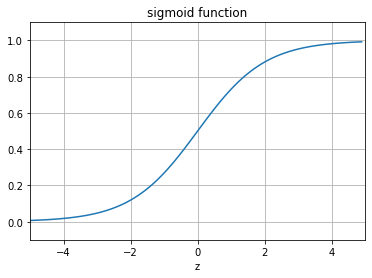

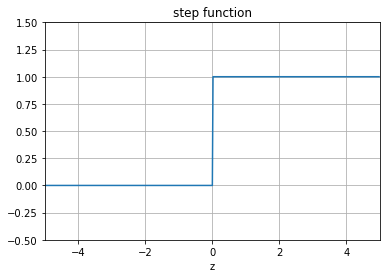

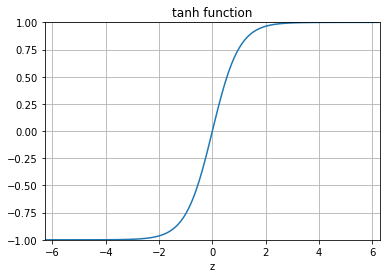

In [1]:
%matplotlib inline

"""The sigmoid function (or the logistic curve) is a
function that takes any real number, z, and outputs a number (0,1).
It is useful in neural networks for assigning weights on a relative scale.
The value z is the weighted sum of parameters involved in the learning algorithm."""

import numpy
import matplotlib.pyplot as plt
import math as mt

z = numpy.arange(-5, 5, .1)
sigma_fn = numpy.vectorize(lambda z: 1/(1+numpy.exp(-z)))
sigma = sigma_fn(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, sigma)
ax.set_ylim([-0.1, 1.1])
ax.set_xlim([-5,5])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('sigmoid function')

plt.show()

"""Step Function"""
z = numpy.arange(-5, 5, .02)
step_fn = numpy.vectorize(lambda z: 1.0 if z >= 0.0 else 0.0)
step = step_fn(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, step)
ax.set_ylim([-0.5, 1.5])
ax.set_xlim([-5,5])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('step function')

plt.show()

"""tanh Function"""
z = numpy.arange(-2*mt.pi, 2*mt.pi, 0.1)
t = numpy.tanh(z)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(z, t)
ax.set_ylim([-1.0, 1.0])
ax.set_xlim([-2*mt.pi,2*mt.pi])
ax.grid(True)
ax.set_xlabel('z')
ax.set_title('tanh function')

plt.show()

## Two parameters

We assume now that we have two classes with $y_i$ either $0$ or $1$. Furthermore we assume also that we have only two parameters $\beta$ in our fitting of the Sigmoid function, that is we define probabilities

$$
\begin{align*}
p(y_i=1|x_i,\hat{\beta}) &= \frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}},\nonumber\\
p(y_i=0|x_i,\hat{\beta}) &= 1 - p(y_i=1|x_i,\hat{\beta}),
\end{align*}
$$

where $\hat{\beta}$ are the weights we wish to extract from data, in our case $\beta_0$ and $\beta_1$. 

Note that we used

$$
p(y_i=0\vert x_i, \hat{\beta}) = 1-p(y_i=1\vert x_i, \hat{\beta}).
$$

<!-- !split  -->
## Maximum likelihood

In order to define the total likelihood for all possible outcomes from a  
dataset $\mathcal{D}=\{(y_i,x_i)\}$, with the binary labels
$y_i\in\{0,1\}$ and where the data points are drawn independently, we use the so-called [Maximum Likelihood Estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) (MLE) principle. 
We aim thus at maximizing 
the probability of seeing the observed data. We can then approximate the 
likelihood in terms of the product of the individual probabilities of a specific outcome $y_i$, that is

$$
\begin{align*}
P(\mathcal{D}|\hat{\beta})& = \prod_{i=1}^n \left[p(y_i=1|x_i,\hat{\beta})\right]^{y_i}\left[1-p(y_i=1|x_i,\hat{\beta}))\right]^{1-y_i}\nonumber \\
\end{align*}
$$

from which we obtain the log-likelihood and our **cost/loss** function

$$
\mathcal{C}(\hat{\beta}) = \sum_{i=1}^n \left( y_i\log{p(y_i=1|x_i,\hat{\beta})} + (1-y_i)\log\left[1-p(y_i=1|x_i,\hat{\beta}))\right]\right).
$$

## The cost function rewritten

Reordering the logarithms, we can rewrite the **cost/loss** function as

$$
\mathcal{C}(\hat{\beta}) = \sum_{i=1}^n  \left(y_i(\beta_0+\beta_1x_i) -\log{(1+\exp{(\beta_0+\beta_1x_i)})}\right).
$$

The maximum likelihood estimator is defined as the set of parameters that maximize the log-likelihood where we maximize with respect to $\beta$.
Since the cost (error) function is just the negative log-likelihood, for logistic regression we have that

$$
\mathcal{C}(\hat{\beta})=-\sum_{i=1}^n  \left(y_i(\beta_0+\beta_1x_i) -\log{(1+\exp{(\beta_0+\beta_1x_i)})}\right).
$$

This equation is known in statistics as the **cross entropy**. Finally, we note that just as in linear regression, 
in practice we often supplement the cross-entropy with additional regularization terms, usually $L_1$ and $L_2$ regularization as we did for Ridge and Lasso regression.

## Minimizing the cross entropy

The cross entropy is a convex function of the weights $\hat{\beta}$ and,
therefore, any local minimizer is a global minimizer. 


Minimizing this
cost function with respect to the two parameters $\beta_0$ and $\beta_1$ we obtain

$$
\frac{\partial \mathcal{C}(\hat{\beta})}{\partial \beta_0} = -\sum_{i=1}^n  \left(y_i -\frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}}\right),
$$

and

$$
\frac{\partial \mathcal{C}(\hat{\beta})}{\partial \beta_1} = -\sum_{i=1}^n  \left(y_ix_i -x_i\frac{\exp{(\beta_0+\beta_1x_i)}}{1+\exp{(\beta_0+\beta_1x_i)}}\right).
$$

## A more compact expression

Let us now define a vector $\hat{y}$ with $n$ elements $y_i$, an
$n\times p$ matrix $\hat{X}$ which contains the $x_i$ values and a
vector $\hat{p}$ of fitted probabilities $p(y_i\vert x_i,\hat{\beta})$. We can rewrite in a more compact form the first
derivative of cost function as

$$
\frac{\partial \mathcal{C}(\hat{\beta})}{\partial \hat{\beta}} = -\hat{X}^T\left(\hat{y}-\hat{p}\right).
$$

If we in addition define a diagonal matrix $\hat{W}$ with elements 
$p(y_i\vert x_i,\hat{\beta})(1-p(y_i\vert x_i,\hat{\beta})$, we can obtain a compact expression of the second derivative as

$$
\frac{\partial^2 \mathcal{C}(\hat{\beta})}{\partial \hat{\beta}\partial \hat{\beta}^T} = \hat{X}^T\hat{W}\hat{X}.
$$

## Extending to more predictors

Within a binary classification problem, we can easily expand our model to include multiple predictors. Our ratio between likelihoods is then with $p$ predictors

$$
\log{ \frac{p(\hat{\beta}\hat{x})}{1-p(\hat{\beta}\hat{x})}} = \beta_0+\beta_1x_1+\beta_2x_2+\dots+\beta_px_p.
$$

Here we defined $\hat{x}=[1,x_1,x_2,\dots,x_p]$ and $\hat{\beta}=[\beta_0, \beta_1, \dots, \beta_p]$ leading to

$$
p(\hat{\beta}\hat{x})=\frac{ \exp{(\beta_0+\beta_1x_1+\beta_2x_2+\dots+\beta_px_p)}}{1+\exp{(\beta_0+\beta_1x_1+\beta_2x_2+\dots+\beta_px_p)}}.
$$

## Including more classes

Till now we have mainly focused on two classes, the so-called binary
system. Suppose we wish to extend to $K$ classes.  Let us for the sake
of simplicity assume we have only two predictors. We have then
following model

1
5
 
<
<
<
!
!
M
A
T
H
_
B
L
O
C
K

$$
\log{\frac{p(C=2\vert x)}{p(K\vert x)}} = \beta_{20}+\beta_{21}x_1,
$$

and so on till the class $C=K-1$ class

$$
\log{\frac{p(C=K-1\vert x)}{p(K\vert x)}} = \beta_{(K-1)0}+\beta_{(K-1)1}x_1,
$$

and the model is specified in term of $K-1$ so-called log-odds or
**logit** transformations.


## More classes

In our discussion of neural networks we will encounter the above again
in terms of a slightly modified function, the so-called **Softmax** function.

The softmax function is used in various multiclass classification
methods, such as multinomial logistic regression (also known as
softmax regression), multiclass linear discriminant analysis, naive
Bayes classifiers, and artificial neural networks.  Specifically, in
multinomial logistic regression and linear discriminant analysis, the
input to the function is the result of $K$ distinct linear functions,
and the predicted probability for the $k$-th class given a sample
vector $\hat{x}$ and a weighting vector $\hat{\beta}$ is (with two
predictors):

$$
p(C=k\vert \mathbf {x} )=\frac{\exp{(\beta_{k0}+\beta_{k1}x_1)}}{1+\sum_{l=1}^{K-1}\exp{(\beta_{l0}+\beta_{l1}x_1)}}.
$$

It is easy to extend to more predictors. The final class is

$$
p(C=K\vert \mathbf {x} )=\frac{1}{1+\sum_{l=1}^{K-1}\exp{(\beta_{l0}+\beta_{l1}x_1)}},
$$

and they sum to one. Our earlier discussions were all specialized to
the case with two classes only. It is easy to see from the above that
what we derived earlier is compatible with these equations.

To find the optimal parameters we would typically use a gradient
descent method.  Newton's method and gradient descent methods are
discussed in the material on [optimization
methods](https://compphysics.github.io/MachineLearning/doc/pub/Splines/html/Splines-bs.html).




## A simple classification problem

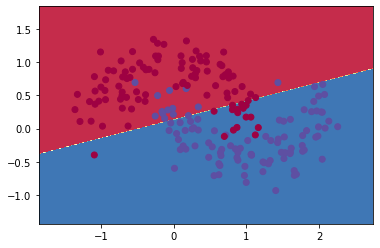

In [2]:
import numpy as np
from sklearn import datasets, linear_model
import matplotlib.pyplot as plt


def generate_data():
    np.random.seed(0)
    X, y = datasets.make_moons(200, noise=0.20)
    return X, y


def visualize(X, y, clf):
    plot_decision_boundary(lambda x: clf.predict(x), X, y)

def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.show()


def classify(X, y):
    clf = linear_model.LogisticRegressionCV()
    clf.fit(X, y)
    return clf


def main():
    X, y = generate_data()
    # visualize(X, y)
    clf = classify(X, y)
    visualize(X, y, clf)

if __name__ == "__main__":
    main()

## Cancer Data again now with Decision Trees and other Methods

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))
#now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Logistic Regression
logreg.fit(X_train_scaled, y_train)
print("Test set accuracy Logistic Regression with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))

(426, 30)
(143, 30)
Test set accuracy with Logistic Regression: 0.95
Test set accuracy Logistic Regression with scaled data: 0.96


/Users/MortenImac/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


## Other measures in classification studies: Cancer Data  again

(426, 30)
(143, 30)
Test set accuracy with Logistic Regression: 0.95
Test set accuracy Logistic Regression with scaled data: 0.96
[1.         1.         1.         1.         1.         1.
 1.         1.         0.92857143 0.92857143]
Test set accuracy with Logistic Regression  and scaled data: 0.96


/Users/MortenImac/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


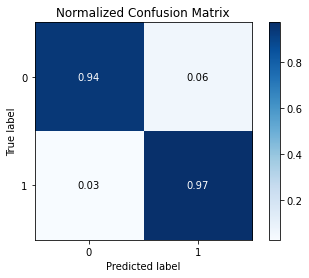

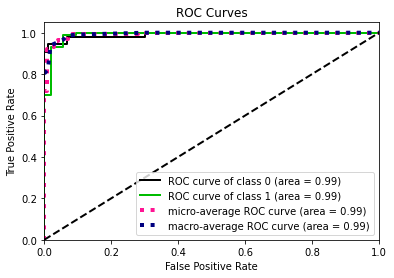

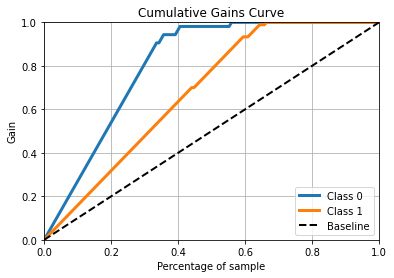

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import  train_test_split 
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression

# Load the data
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data,cancer.target,random_state=0)
print(X_train.shape)
print(X_test.shape)
# Logistic Regression
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_train, y_train)
print("Test set accuracy with Logistic Regression: {:.2f}".format(logreg.score(X_test,y_test)))
#now scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Logistic Regression
logreg.fit(X_train_scaled, y_train)
print("Test set accuracy Logistic Regression with scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
#Cross validation
accuracy = cross_validate(logreg,X_test_scaled,y_test,cv=10)['test_score']
print(accuracy)
print("Test set accuracy with Logistic Regression  and scaled data: {:.2f}".format(logreg.score(X_test_scaled,y_test)))


import scikitplot as skplt
y_pred = logreg.predict(X_test_scaled)
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()
y_probas = logreg.predict_proba(X_test_scaled)
skplt.metrics.plot_roc(y_test, y_probas)
plt.show()
skplt.metrics.plot_cumulative_gain(y_test, y_probas)
plt.show()